In [1]:
%cd drive/MyDrive/Biocreative/

/content/drive/MyDrive/Biocreative


In [2]:
!nvidia-smi

Mon Aug  9 07:43:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### main model

In [3]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 11.3 MB/s 
     |████████████████████████████████| 895 kB 41.7 MB/s 
     |████████████████████████████████| 3.3 MB 40.3 MB/s 
     |████████████████████████████████| 636 kB 46.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
!pip install pytorch-lightning

     |████████████████████████████████| 915 kB 10.9 MB/s 
     |████████████████████████████████| 118 kB 51.3 MB/s 
     |████████████████████████████████| 5.6 MB 42.3 MB/s 
     |████████████████████████████████| 234 kB 40.7 MB/s 
     |████████████████████████████████| 829 kB 44.5 MB/s 
     |████████████████████████████████| 1.3 MB 41.6 MB/s 
     |████████████████████████████████| 142 kB 50.8 MB/s 
     |████████████████████████████████| 294 kB 44.3 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=54979af442447c32dd045e01cdd1eb895b1e8e8d74f5d2bd656cc67908c8b1ee
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully uninstalled tensorboard-2.5.0
  Attempting uninstall: future
    Found existing installation: future 0.16.0
 

In [47]:
!pip install torchmetrics

In [48]:
import pandas as pd
import numpy as np

import random
from collections import defaultdict

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy, f1
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from torchmetrics.functional.classification.auroc import auroc

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline  
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

pl.seed_everything(RANDOM_SEED)

Global seed set to 42


42

In [6]:
df = pd.read_csv('Biocreative/preprocessed.csv')
df.head()

,abstract,Case Report,Diagnosis,Epidemic Forecasting,Mechanism,Prevention,Transmission,Treatment
0,December 2019 new highly contagious infectious...,0,0,0,1,0,0,1
1,"novel coronavirus disease COVID-19 , transmitt...",0,0,0,0,1,0,1
2,BACKGROUND December 2019 novel coronavirus SAR...,1,0,0,0,0,0,0
3,coronavirus disease 2019 COVID-19 pandemic imp...,0,0,0,0,1,0,0
4,OBJECTIVES Sofosbuvir daclatasvir direct-actin...,0,0,0,0,0,0,1


In [7]:
train_df, val_df = train_test_split(df, test_size=0.1)
train_df.shape, val_df.shape

((22464, 8), (2496, 8))

In [8]:
LABEL_COLUMNS = df.columns.tolist()[1:]

In [9]:
BERT_MODEL_NAME = 'dmis-lab/biobert-base-cased-v1.1'
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)

----
### testing current approach 
----
*Note: below code is processed on single example*
- tokenization
- concationation of sequence and label encodings
- pass through model
- compute loss *(BCELoss)*

In [94]:
sample_item = train_df.abstract[0]
print(sample_item)
encoding = tokenizer.encode_plus(
    sample_item,
    add_special_tokens=True,
    max_length=511,
    return_token_type_ids=False,
    padding="max_length",
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt',
)
encoding.keys()

December 2019 new highly contagious infectious disease emerged Wuhan China etiologic agent identified novel coronavirus known Severe Acute Syndrome Coronavirus-2 SARS-CoV-2 . Recent research revealed virus entry take place upon union virus surface protein type transmembrane metallo-carboxypeptidase angiotensin converting enzyme 2 ACE-2 identified epithelial cell host respiratory tract Virus trigger synthesis release pro-inflammatory cytokine including IL-6 TNF-alpha also promotes downregulation ACE-2 promotes concomitant increase level angiotensin II AT-II . TNF-alpha AT-II implicated promoting overexpression tissue factor TF platelet macrophage Additionally generation antiphospholipid antibody associated COVID-19 may also promote increase TF TF may critical mediator associated development thrombotic phenomenon COVID-19 target future study


dict_keys(['input_ids', 'attention_mask'])

In [95]:
encoding["input_ids"].shape, encoding["attention_mask"].shape

(torch.Size([1, 511]), torch.Size([1, 511]))

In [96]:
# encoding labels
sample = train_df.iloc[0]
label_dict = sample[1:].to_dict()
true_labels = [key for key, value in label_dict.items() if value == 1]
print(true_labels)
# see something for multiple labels

['Mechanism', 'Treatment']


In [97]:
label_encoding = tokenizer.encode_plus(
    true_labels[0],
    add_special_tokens=False,
    return_tensors="pt",
    return_token_type_ids=False
)
label_encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [98]:
label_encoding["input_ids"], tokenizer.convert_ids_to_tokens(label_encoding["input_ids"])

(tensor([[6978]]), ['mechanism'])

In [99]:
abstract_input = encoding["input_ids"]
label_input = label_encoding["input_ids"]
input_tensor = torch.cat((abstract_input, label_input), 1)
print(f"abstract input encoding shape {abstract_input.shape}")
print(f"label input encoding shape {label_input.shape}")
print(f"resultant input encoding shape {input_tensor.shape}")

abstract input encoding shape torch.Size([1, 511])
label input encoding shape torch.Size([1, 1])
resultant input encoding shape torch.Size([1, 512])


In [18]:
# same goes with attention mask
attention_tensor = torch.cat((encoding["attention_mask"], label_encoding["attention_mask"]), 1)
print(attention_tensor.shape)

torch.Size([1, 512])


In [19]:
# initialize bert model
bert_model = AutoModel.from_pretrained(BERT_MODEL_NAME)

Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.1 were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
output = bert_model(input_tensor, attention_tensor)
print(output.last_hidden_state.shape, output.pooler_output.shape)

torch.Size([1, 512, 768]) torch.Size([1, 768])


In [21]:
# fully connected layer
fc_layer = nn.Linear(bert_model.config.hidden_size, 1)

In [22]:
Output = fc_layer(output.pooler_output)
Output

tensor([[-0.0301]], grad_fn=<AddmmBackward>)

In [23]:
# define criterion
criterion = nn.BCELoss()

In [24]:
truth_value = torch.Tensor([1])
truth_value.shape

torch.Size([1])

In [25]:
torch.sigmoid(Output)

tensor([[0.4925]], grad_fn=<SigmoidBackward>)

In [26]:
truth_value = torch.Tensor([1])

In [27]:
loss = criterion(torch.sigmoid(Output), truth_value.view(1, 1))
loss

tensor(0.7083, grad_fn=<BinaryCrossEntropyBackward>)

----
### uncomment below cells to create ZSL data
----
- *Note*: data has already been created @ /Biocreative/ZSL.csv

In [ ]:
# Dataset Format 
# -----------------------------------
# |Sequence 1 | Annotation1 | Label |
# -----------------------------------
# |Sequence 2 | Annotation2 | Label |
# -----------------------------------

In [ ]:
# def positive_data(example):

#   sequence = [example["abstract"]]
#   label_dict = example[1:].to_dict()
#   labels = [key for key, value in label_dict.items() if value == 1]
#   return zip(sequence * len(labels), labels)

In [ ]:
# def negative_data(example):

#   sequence = [example["abstract"]]
#   label_dict = example[1:].to_dict()
#   labels = [key for key, value in label_dict.items() if value != 1]
#   label = labels[random.randint(0, len(labels)-1)]
#   return zip(sequence, [label])

In [ ]:
# # conversion sequece
# train_dict = defaultdict(list)

# for idx, row in df.iterrows():
#   zipped_object = positive_data(row)
#   for key, value in zipped_object:
#     train_dict["Sequence"].append(key)
#     train_dict["Label"].append(value)
#     train_dict["Truth_Value"].append(True)
  
#   zipped_object = negative_data(row)
#   for key, value in zipped_object:
#     train_dict["Sequence"].append(key)
#     train_dict["Label"].append(value)
#     train_dict["Truth_Value"].append(False)    

In [ ]:
# ZSL_df = pd.DataFrame.from_dict(train_dict, orient='index').T
# ZSL_df = ZSL_df.sample(frac=1).reset_index(drop=True)

In [ ]:
# ZSL_df.to_csv('drive/MyDrive/Biocreative/Biocreative/ZSL.csv', index=False)

In [ ]:
# data = pd.read_csv('Biocreative/ZSL.csv')
# data.rename(columns={
#     "Label": "Annotation",
#     "Truth_Value": "Label"
# }, inplace=True, errors='raise')
# data.head()

In [73]:
# data.to_csv('Biocreative/ZSL.csv', index=False)

In [88]:
# convert true/fa;se to 0/1
# data = pd.read_csv('Biocreative/ZSL.csv')
# data.Label = data.Label.astype(bool)
# data.head()
# data.to_csv('Biocreative/ZSL.csv', index=False)

,Sequence,Annotation,Label
0,PURPOSE analyse complication outcome COVID-19 ...,Mechanism,False
1,BACKGROUND Asymptomatic individual SARS-CoV-2 ...,Diagnosis,True
2,BACKGROUND COVID-19 critical pandemic affected...,Transmission,False
3,BACKGROUND Coronavirus disease 2019 COVID-19 p...,Epidemic Forecasting,False
4,safe effective vaccine candidate urgently need...,Mechanism,True


### continuation

In [28]:
#load ZSL data and start creating a model

In [10]:
data = pd.read_csv('Biocreative/ZSL.csv')
data.head()

,Sequence,Annotation,Label
0,PURPOSE analyse complication outcome COVID-19 ...,Mechanism,False
1,BACKGROUND Asymptomatic individual SARS-CoV-2 ...,Diagnosis,True
2,BACKGROUND COVID-19 critical pandemic affected...,Transmission,False
3,BACKGROUND Coronavirus disease 2019 COVID-19 p...,Epidemic Forecasting,False
4,safe effective vaccine candidate urgently need...,Mechanism,True


In [11]:
train_df, val_df = train_test_split(data, test_size=0.05)
train_df.shape, val_df.shape

((56240, 3), (2960, 3))

## data analysis


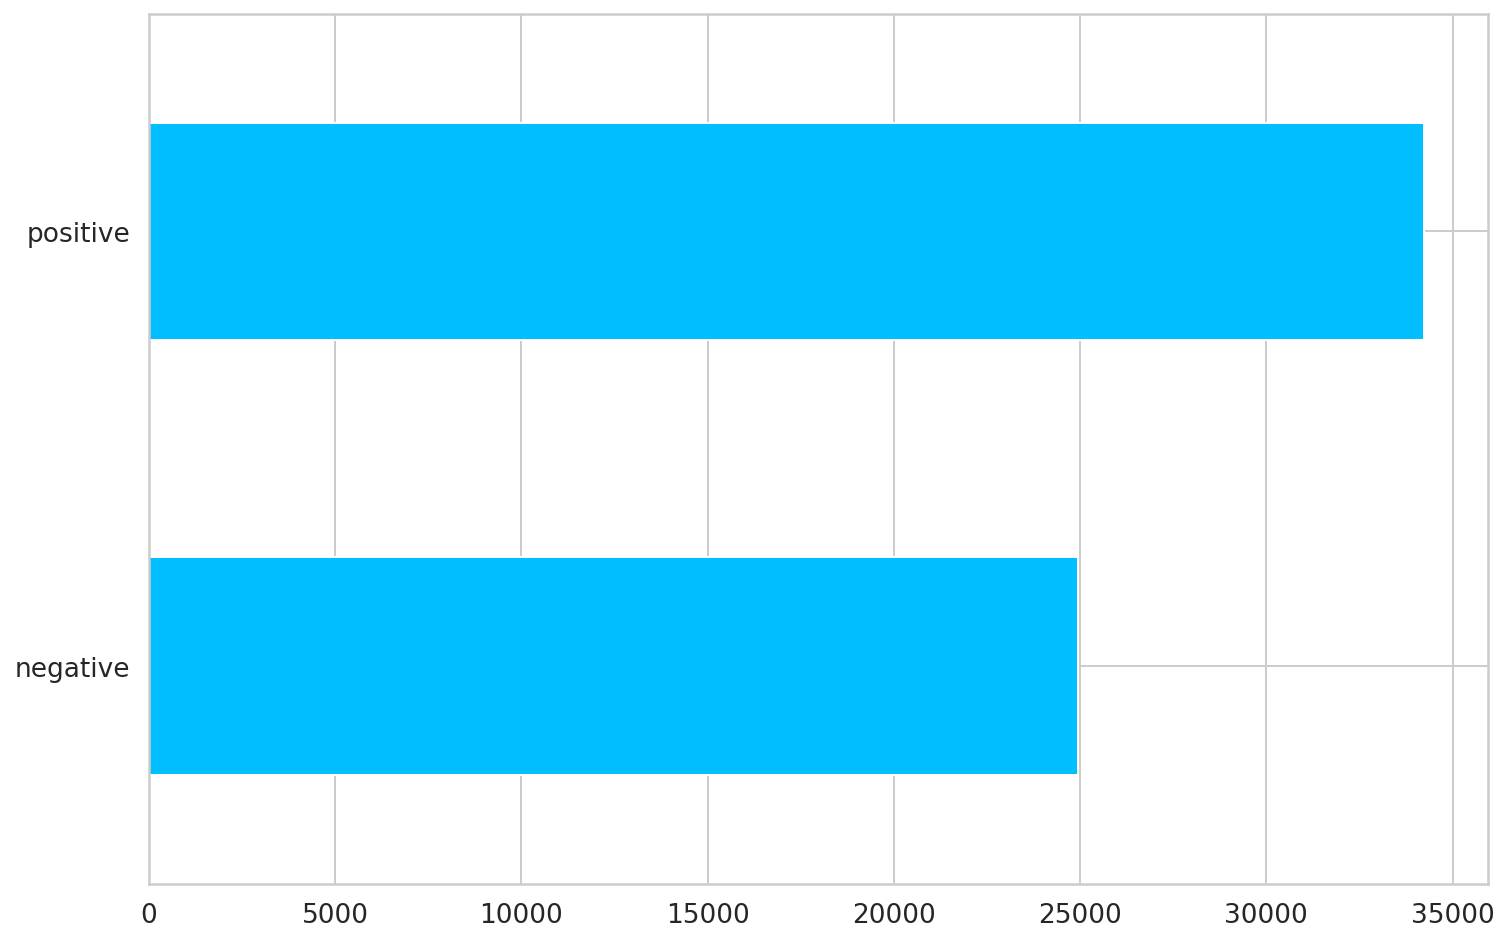

In [12]:
pd.Series([(data.Label).sum(), (~data.Label).sum()], ["positive", "negative"]).sort_values().plot(kind="barh")

(0.0, 512.0)

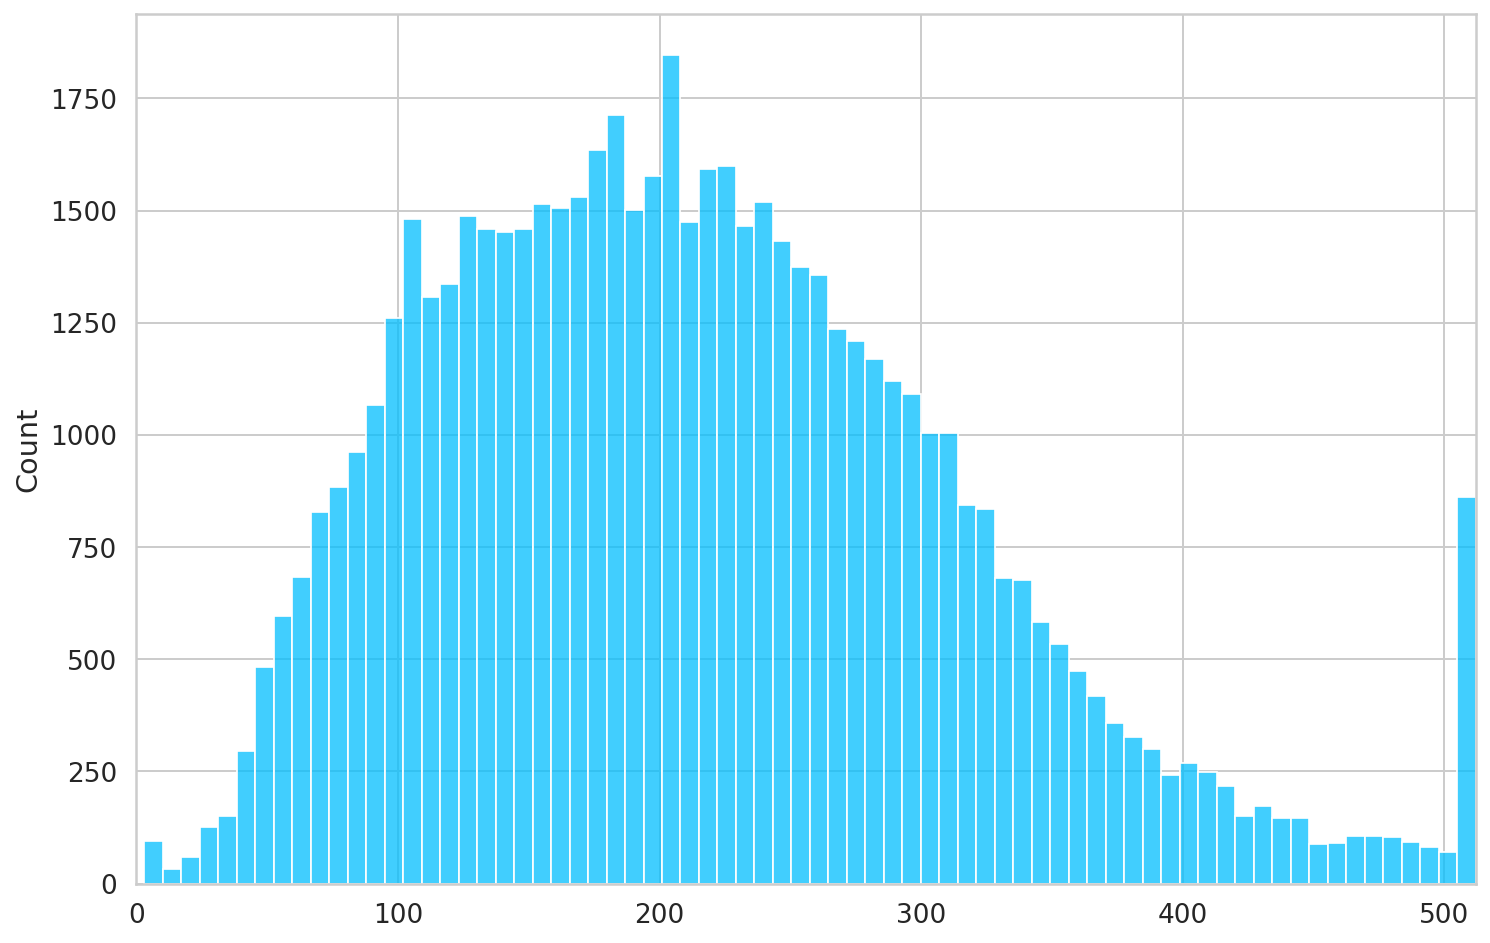

In [13]:
token_counts = []

for _, row in data.iterrows():
  token_count = len(tokenizer.encode(
      row["Sequence"],
      max_length=512,
      truncation=True
  ))

  token_counts.append(token_count)

sns.histplot(token_counts)
plt.xlim([0, 512])

In [14]:
# key observation: around 875 sentence are getting truncated and thus model will ignore the end context of those sequences.

----
## model classes 
----
- TopicAnnotationDataset
- TopicAnnotationDataLoader
- TopicAnnotationTagger

In [15]:
# TopicAnnotationDataset
# TopicAnnotationDataLoader
# TopicAnnotationTagger

In [16]:
MAX_TOKEN_COUNT = 512

In [17]:
class TopicAnnotationDataset(Dataset):

  def __init__(
    self,
    data: pd.DataFrame,
    tokenizer: AutoTokenizer,
    max_token_len: int = 128
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len

  def __len__(self):
    return len(self.data)

  def concat_tensors(self, tensor1, tensor2):
    return torch.cat((tensor1, tensor2), 1)

  def __getitem__(self, index=int):
    
    data_row = self.data.iloc[index]

    sequence = data_row.Sequence
    annotation = data_row.Annotation
    label = data_row.Label.astype(int)

    sequence_encoding = self.tokenizer.encode_plus(
        sequence,
        add_special_tokens=True,
        max_length=self.max_token_len-3,
        return_token_type_ids=False,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    label_encoding = self.tokenizer.encode_plus(
        annotation,
        max_length=3,
        padding="max_length",
        add_special_tokens=False,
        return_token_type_ids=False,
        return_attention_mask=True,
        return_tensors="pt",
    )

    encoding = {
        "input_ids": self.concat_tensors(sequence_encoding["input_ids"], label_encoding["input_ids"]),
        "attention_mask": self.concat_tensors(sequence_encoding["attention_mask"], label_encoding["attention_mask"])
    }

    return dict(
        text=f"{sequence} {annotation}",
        input_ids=encoding["input_ids"].flatten(),
        attention_mask=encoding["attention_mask"].flatten(),
        label=torch.FloatTensor([label]) 
    )  

In [18]:
train_dataset = TopicAnnotationDataset(
    train_df,
    tokenizer,
    max_token_len=MAX_TOKEN_COUNT
)
sample_item = train_dataset[0]
sample_item.keys()

dict_keys(['text', 'input_ids', 'attention_mask', 'label'])

In [19]:
sample_item["input_ids"].shape, sample_item["attention_mask"].shape

(torch.Size([512]), torch.Size([512]))

----
### implementing a sample batch on bert model
----

In [20]:
bert_model = AutoModel.from_pretrained(BERT_MODEL_NAME)

Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.1 were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
sample_batch = next(iter(DataLoader(train_dataset, batch_size=8, num_workers=2)))
sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape

(torch.Size([8, 512]), torch.Size([8, 512]))

In [22]:
output = bert_model(sample_batch["input_ids"], sample_batch["attention_mask"])

In [23]:
output.last_hidden_state.shape, output.pooler_output.shape

(torch.Size([8, 512, 768]), torch.Size([8, 768]))

In [24]:
output.pooler_output

tensor([[-0.1665,  0.0166,  0.9807,  ...,  0.9871, -0.2265,  0.9999],
        [-0.0495,  0.1043,  0.9562,  ...,  0.9703, -0.1793,  0.9998],
        [-0.1118,  0.1557,  0.9684,  ...,  0.9845, -0.2254,  1.0000],
        ...,
        [-0.0729,  0.0280,  0.9735,  ...,  0.9833, -0.2457,  0.9998],
        [-0.0466,  0.1762,  0.9508,  ...,  0.9637, -0.1084,  0.9997],
        [ 0.0209,  0.1466,  0.8724,  ...,  0.9168, -0.1825,  0.9995]],
       grad_fn=<TanhBackward>)

In [25]:
# last hidden state shape
bert_model.config.hidden_size

768

### continutation

In [26]:
class TopicAnnotationDataModule(pl.LightningDataModule):

  def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
    
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  def setup(self, stage=None):
    
    self.train_dataset =  TopicAnnotationDataset(
        self.train_df,
        self.tokenizer,
        self.max_token_len
    )

    self.test_dataset = TopicAnnotationDataset(
        self.test_df,
        self.tokenizer,
        self.max_token_len
    )

  def train_dataloader(self):

    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=2
    )

  def val_dataloader(self):

    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

  def test_dataloader(self):
    
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

In [27]:
N_EPOCHS = 10
BATCH_SIZE = 8

data_module = TopicAnnotationDataModule(
    train_df,
    val_df,
    tokenizer,
    batch_size=BATCH_SIZE,
    max_token_len=MAX_TOKEN_COUNT
)

In [38]:
class TopicAnnotationTagger(pl.LightningModule):

  def __init__(
      self,
      n_classes: int,
      n_training_steps=None,
      n_warmup_steps=None
  ):

    super().__init__()
    self.bert = AutoModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.classifier = nn.Linear(self.bert.config.hidden_size, 1)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss()

  def forward(self, input_ids, attention_mask, labels=None):

    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)
    loss = 0
    if labels is not None:
      loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):

    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["label"]

    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def validation_step(self, batch, batch_idx):

    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["label"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["label"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  def training_epoch_end(self, outputs):

    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)

    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)

    for i, name in enumerate(LABEL_COLUMNS):
      class_roc_auc = auroc(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)

  def configure_optimizers(self):

    optimizer = AdamW(self.parameters(), lr=2e-5)

    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )

    return dict(
        optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

In [39]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

In [40]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(14060, 70300)

In [41]:
model = TopicAnnotationTagger(
    n_classes=len(LABEL_COLUMNS),
    n_warmup_steps=warmup_steps,
    n_training_steps=total_training_steps
)

Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.1 were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [42]:
checkpoint_callback = ModelCheckpoint(
    dirpath="ZSL_checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

In [43]:
logger = TensorBoardLogger("ZSL_lightning_logs", name="topic-annotations")

In [44]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

In [45]:
trainer = pl.Trainer(
    logger=logger,
    checkpoint_callback=True,
    callbacks=[checkpoint_callback, early_stopping_callback],
    max_epochs=N_EPOCHS,
    gpus=-1,
    progress_bar_refresh_rate=30
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [46]:
trainer.fit(model, data_module)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.prepare_data has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.prepare_data.
  f"DataModule.{name} has already been called, so it will not be called again. "
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 108 M 
1 | classifier | Linear    | 769   
2 | criterion  | BCELoss   | 0     
-----------------------------------------
108 M     Trainable params
0         Non-trainable 

Global seed set to 42


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:398: LightningDeprecationWarning: One of the returned values {'predictions', 'labels'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  f"One of the returned values {set(extra.keys())} has a `grad_fn`. We will detach it automatically"


/usr/local/lib/python3.7/dist-packages/deprecate/deprecation.py:115: LightningDeprecationWarning: The `auroc` was deprecated since v1.3.0 in favor of `torchmetrics.functional.classification.auroc.auroc`. It will be removed in v1.5.0.
  stream(template_mgs % msg_args)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:37: UserWarning: `pos_label` automatically set 1.
  warnings.warn(*args, **kwargs)


IndexError: ignored

In [ ]:
# train_at_epoch_end is functioning oddly so see through it by the end of the day